In [1]:
# Needed imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Exercício 1
owid_energy_data = pd.read_csv('owid-energy-data.csv')
countries = ['United States', 'Canada', 'Brazil', 'Mexico']
filtered_index = owid_energy_data.country.isin(countries)
energy_data = owid_energy_data[filtered_index]
energy_data.to_csv('filtered-energy-data.csv')

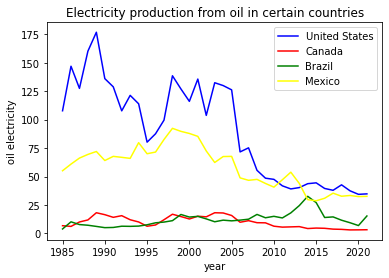

In [3]:
# Exercício 2
plt.figure()
colors = ['blue', 'red', 'green', 'yellow']

for country, color in zip(countries, colors):
    data = energy_data[(energy_data.country == country)
                       & (energy_data['oil_electricity'].notnull())]
    plt.plot(data.year, data['oil_electricity'], '-', color=color, label=country)

plt.xlabel('year')
plt.ylabel('oil electricity')
plt.title('Electricity production from oil in certain countries')
plt.legend()
plt.show()

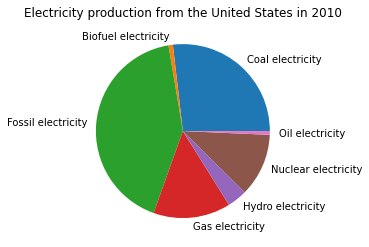

In [4]:
# Exercício 3
usa_energy_data = energy_data[(energy_data.country == 'United States')
                              & (energy_data.year == 2010)]

elec_sources = ['coal_electricity', 'biofuel_electricity',
                'fossil_electricity', 'gas_electricity',
                'hydro_electricity', 'nuclear_electricity',
                'oil_electricity']

usa_electricity = usa_energy_data[elec_sources].values.flatten().tolist()

plt.figure()
plt.title('Electricity production from the United States in 2010')
elec_sources = [s.replace('_', ' ').capitalize() for s in elec_sources]
plt.pie(usa_electricity, labels=elec_sources)
plt.show()

In [5]:
# Exercício 4
def highest_nuclear_consumption(country: str) -> np.float64:
    country_data: pd.DataFrame = energy_data.loc[(energy_data.country == country),
                                                 ['year', 'nuclear_consumption']]
    i = country_data['nuclear_consumption'].idxmax()
    year = country_data.loc[i, 'year']
    consumption = country_data.loc[i, 'nuclear_consumption']
    print(f'Nuclear consumption of {country} in {year} was {consumption}')
    return consumption

In [6]:
print('Highest nuclear consumption year per country:')
[highest_nuclear_consumption(country) for country in countries]

Highest nuclear consumption year per country:
Nuclear consumption of United States in 2007 was 2254.808
Nuclear consumption of Canada in 1994 was 297.456
Nuclear consumption of Brazil in 2012 was 41.311
Nuclear consumption of Mexico in 2013 was 30.211


[2254.808, 297.456, 41.311, 30.211]

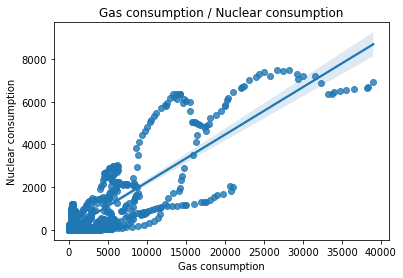

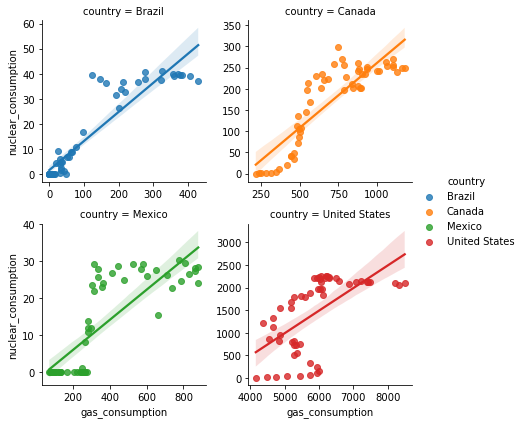

In [7]:
# Exercício 5
sns.regplot(data=owid_energy_data, x='gas_consumption', y='nuclear_consumption')

plt.xlabel('Gas consumption')
plt.ylabel('Nuclear consumption')
plt.title(f'Gas consumption / Nuclear consumption')

grid = sns.FacetGrid(energy_data, col="country", hue="country", col_wrap=2,
                     sharex=False, sharey=False)
grid.map(sns.regplot, 'gas_consumption', 'nuclear_consumption')
grid.add_legend()
plt.show()

In [9]:
# Task 6 - Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

pd.options.mode.chained_assignment = None

In [10]:
# United States solar data
energy_data = pd.read_csv('filtered-energy-data.csv')

solar_data: pd.DataFrame = energy_data.loc[
    (energy_data.country == countries[0]) & (energy_data.solar_consumption.notnull()),
    ['year', 'solar_consumption']]

solar_data.set_index('year', inplace=True)

y = solar_data['solar_consumption'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

In [11]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 3  # length of input sequences (lookback period)
n_forecast = 1  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [12]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=500, batch_size=50)

In [ ]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

In [ ]:
# organize the results in a data frame
df_past = solar_data[['solar_consumption']].reset_index()
df_past.rename(columns={'index': 'year', 'solar_consumption': 'Actual'}, inplace=True)
df_past['year'] = pd.date_range(start=solar_data.index[0],
                                periods=len(solar_data), freq='AS')
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['year', 'Actual', 'Forecast'])

df_future['year'] = pd.date_range(start=df_past['year'].iloc[-1] + pd.DateOffset(months=12),
                                  periods=n_forecast, freq='AS')
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = pd.concat([df_past, df_future]).set_index('year')

In [ ]:
# plot the results
results.plot(title=f'Solar consumption of {countries[0]}')
plt.show()